# Author: Yoonhyuck WOO / JBNU_Industrial Information system Engineering
# Date; 3. 7. 2022 - 3. 17. 2022
# Title: Korean_NER
# Professor: Seung-Hoon Na

In [1]:
from torch import cuda

device = 'cuda' if cuda.is_available() else 'cpu'

print(device)

cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
pip install transformers

     |████████████████████████████████| 3.8 MB 5.4 MB/s 
     |████████████████████████████████| 596 kB 51.5 MB/s 
     |████████████████████████████████| 6.5 MB 19.3 MB/s 
     |████████████████████████████████| 895 kB 53.8 MB/s 
     |████████████████████████████████| 67 kB 5.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
import os
import json
import numpy as np
from functools import partial
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertModel, FlaubertModel
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# BertTokenizer
 - return tensors = "pt" : Finally, you want the tokenizer to return the actual tensors that are fed to the model.
 
# BertModel
 - Attention_mask : 1 where you care and 0 where you don't care.
 - Input_ids : the IDs of the sentence morpheme.
 - Token_type_ids : for the question problem, but it's enough to set it to zero now.

reference: https://huggingface.co/docs/transformers/model_doc/bert

# Example

In [5]:
PRETAINED_MODEL_NAME = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(PRETAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

# Loading Data

In [6]:
PATH_dir = '/content/drive/My Drive/Colab Notebooks/Ko_En_NER_POStag_data/Ko_NER_POS/'
PATH_ko_train = os.path.join(PATH_dir, 'prepro_train.json')
PATH_ko_test = os.path.join(PATH_dir, 'prepro_test.json')
PATH_ko_dev = os.path.join(PATH_dir, 'prepro_dev.json')
total_tag = os.path.join(PATH_dir, 'total_tag.json')

In [7]:
with open(PATH_ko_dev) as data_file:
  dataset_dev = json.load(data_file)
with open(PATH_ko_test) as data_file:
  dataset_test = json.load(data_file)
with open(PATH_ko_train) as data_file:
  dataset_train = json.load(data_file) 

In [8]:
print('train', len(dataset_train))
print('test', len(dataset_test))
print('dev', len(dataset_dev))
# tag_converter.id_to_tag

train 4250
test 500
dev 250


# convert_Tag_to_id

In [9]:
def convert_Tag_to_id_list(batch):
  tag_to_id ={'PAD': 0, 'B-<휠': 1, 'B-OG': 2, 'I-조선': 3, 'I-PS': 4, 'B-LC': 5, 'B-1': 6, 'I-<휠': 7, 'I-LC': 8, 'B-PS': 9, 'I-TI': 10, 
              'B-목소': 11, 'O': 12, 'I-목소': 13, 'I-1': 14, 'I-': 15, 'B-조선': 16, 'I-OG': 17, 'B-': 18, 'I-DT': 19, 'B-TI': 20, 'B-DT': 21}
  total = []
  t_to_i = []
  for j in batch:
      j = tag_to_id.get(j)
      t_to_i.append(j)

  return t_to_i

# convert_id_to_tag

In [10]:
def convert_id_to_tag_list(batch):
  id_to_tag ={0: '[PAD]', 1: 'B-<휠', 2: 'B-OG', 3: 'I-조선', 4: 'I-PS', 5: 'B-LC', 6: 'B-1', 7: 'I-<휠', 8: 'I-LC', 9: 'B-PS', 
              10: 'I-TI', 11: 'B-목소', 12: 'O', 13: 'I-목소', 14: 'I-1', 15: 'I-', 16: 'B-조선', 17: 'I-OG', 18: 'B-', 19: 'I-DT', 20: 'B-TI', 21: 'B-DT'}
  total = []
  i_to_t = []
  for j in batch:
      j = id_to_tag.get(j)
      i_to_t.append(j)

  return i_to_t

In [11]:
convert_Tag_to_id_list(['O','I-목소'])

[12, 13]

In [12]:
convert_id_to_tag_list([12, 13])

['O', 'I-목소']

# Make Batch & Padding

In [13]:
def make_batch(labels, max_len):
  batch_labels = []
  special_token = 0

  for taglist in labels:
    sample = [special_token] + convert_Tag_to_id_list(taglist)[:max_len-2] + [special_token]
    sample +=[special_token] * max(0, max_len - (len(sample)))
    batch_labels.append(sample)
    # print(batch_labels)
    
  return torch.tensor(batch_labels)

In [14]:
tag = [['B-OG', 'I-OG', 'I-조선', 'I-OG', 'I-OG', 'I-DT'],  # 0, 2, 17, 3, 17, 17, 19, 0
       ['O', 'B-DT', 'I-DT', 'B-DT', 'I-DT', 'I-DT', 'I-DT', 'I-DT', 'B-LC','O', 'O', 'B-OG', 'I-OG', 'I-OG', 'I-OG'], 
       ['I-OG', 'O', 'O', 'O', 'B-PS', 'O', 'B-PS', 'I-PS', 'I-PS', 'O', 'B-LC', 'O', 'O', 'B-OG',], 
       ['B-PS', 'O', 'O', 'O', 'O', 'O', 'O', 'O','O', 'O', 'O', 'O', 'I-DT','I-PS', 'I-PS']]

In [15]:
make_batch(tag,17)

tensor([[ 0,  2, 17,  3, 17, 17, 19,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0, 12, 21, 19, 21, 19, 19, 19, 19,  5, 12, 12,  2, 17, 17, 17,  0],
        [ 0, 17, 12, 12, 12,  9, 12,  9,  4,  4, 12,  5, 12, 12,  2,  0,  0],
        [ 0,  9, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 19,  4,  4,  0]])

In [16]:
print(len(tag[0]), len(tag[1]) ,len(tag[2]) ,len(tag[3]))

6 15 14 15


In [17]:
def ner_fn_custom(tokenizer, make_batch, data):
    
    input_sent = [sample[0] for sample in data]
    labels = [sample[2] for sample in data]

    batch_inputs = tokenizer(input_sent, padding = True, return_tensors = "pt")
    batch_labels = make_batch(labels, max_len = batch_inputs['input_ids'].size(1))

    return batch_inputs, batch_labels

In [18]:
batch_size = 15
# partial (func, /, *args, **keywords)  positional argument: args, keyword argument: keywords

# partial_collate_fn = partial(collate_fn_custom, tokenizer, tag_converter)
# partial_collate_fn = collate_fn_custom

partial_collate_fn = partial(ner_fn_custom, tokenizer, make_batch)
'''
partial_collate_fn = partial(collate_fn_custom, tokenizer, tag_converter)
'''
# ner_collate_fn: padding & making batch?
'''
def ner_collate_fn(tokenizer, tag_converter):
    
'''

'\ndef ner_collate_fn(tokenizer, tag_converter):\n    \n'

# DataLoader
- responsible for deployment management
- easier to repeat the arrangement.
- automatically provide individual mini-batch

reference: https://hulk89.github.io/pytorch/2019/09/30/pytorch_dataset/

In [19]:
dataloader_train = DataLoader(
    dataset_train,
    batch_size = batch_size,
    shuffle = True,
    collate_fn = partial_collate_fn)

dataloader_test = DataLoader(
    dataset_test,
    batch_size = batch_size,
    shuffle = False,
    collate_fn = partial_collate_fn)

dataloader_dev = DataLoader(
    dataset_dev,
    batch_size = batch_size,
    shuffle = False,
    collate_fn = partial_collate_fn)

#Bert_NER Model
 - Dropout: method to solve overfitting, one of the problems in deep learning learning. In summary, how to prevent some units of the hidden layer from being overfitted by inoperative<br>
    ->the outputs are scaled by a factor of (1 / 1-p)  during training

# *args, **kargs
 - *args(non-keworded arguments): Tuple type of argument without limitation.
 - **kargs(keworded arguments):  Dictionary type of argument without limitation.

# nn.Module
 - model.train() & model.eval(): A function that switches to perform other tasks performed at train time and eval time.

   - Typical examples of how to operate differently at train time and eval time are: Dropout Layer, BatchNorm Layer, etc

reference: https://bluehorn07.github.io/2021/02/27/model-eval-and-train.html

In [20]:
class Bert_NER(nn.Module):  
    def __init__(self, bert):
        super().__init__() 
        bert = BertModel.from_pretrained(PRETAINED_MODEL_NAME)     
        self.bert = bert
        self.dropout = nn.Dropout(p = 0.1)
        self.linear = nn.Linear(768, 22)
        self.softmax = nn.Softmax(dim = 2) # A dimension along which Softmax will be computed
    
    def forward(self, **kwargs):
        emb = self.bert(**kwargs)
        e = self.dropout(emb['last_hidden_state'])
        w = self.linear(e)
        
        return w

In [21]:
# tag_num = len(tag_to_id) # <=22 
'''tag_to_id ={'PAD': 0, 'B-<휠': 1, 'B-OG': 2, 'I-조선': 3, 'I-PS': 4, 'B-LC': 5, 'B-1': 6, 'I-<휠': 7, 'I-LC': 8, 'B-PS': 9, 'I-TI': 10, 
   'B-목소': 11, 'O': 12, 'I-목소': 13, 'I-1': 14, 'I-': 15, 'B-조선': 16, 'I-OG': 17, 'B-': 18, 'I-DT': 19, 'B-TI': 20, 'B-DT': 21}'''
model = Bert_NER(22)

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
model.cuda()
device = model.bert.device

In [23]:
print(device)

cuda:0


# nn.CrossEntropyLoss
 :Integrated classes with LogSoftmax and NLLLoss == softmax -> log -> negative to positive and mean/sum

 # LogSoftmax
 : softmax makes probability distribution with a sum of 1, and the probability distribution was taken by log

# NLLLoss (Negative Log Likelihood Loss)
- Obtaining log-probabilities in a neural network is easily achieved by adding a LogSoftmax layer in the last layer of your network
- The expression is loss=-weight*input to change the negative to positive, and the sum or average value is obtained by sigma calculation and used as loss.
- negative log (-log)
   - the closer the predicted probability is to 1, the smaller the loss is
   - and the closer the predicted probability is to 0, the greater the loss is
   - Given that entropy is instability or uncertainty => learning in the form of strict regulation of incorrect answers and praise for good judgments close to correct answers in order to create a confident model.

reference: https://blog.naver.com/PostView.naver?blogId=vail131&logNo=222474864230&parentCategoryNo=&categoryNo=21&viewDate=&isShowPopularPosts=true&from=search

In [24]:
CELoss = nn.CrossEntropyLoss(ignore_index = 0)
optimizer = AdamW(model.parameters(), lr = 1.0e-4)
draw = []

# Training

 29 - loss: 0.4894633889198303
 59 - loss: 0.2024410218000412
 89 - loss: 0.14854928851127625
119 - loss: 0.2380889356136322
149 - loss: 0.1444547176361084
179 - loss: 0.18795844912528992
209 - loss: 0.21019108593463898
239 - loss: 0.09277631342411041
269 - loss: 0.13180820643901825
epoch1: 완료

 29 - loss: 0.08963720500469208
 59 - loss: 0.11527306586503983
 89 - loss: 0.1689687967300415
119 - loss: 0.09851089119911194
149 - loss: 0.11384034156799316
179 - loss: 0.08039460331201553
209 - loss: 0.12538671493530273
239 - loss: 0.11499526351690292
269 - loss: 0.17312054336071014
epoch2: 완료



Text(0, 0.5, 'loss')

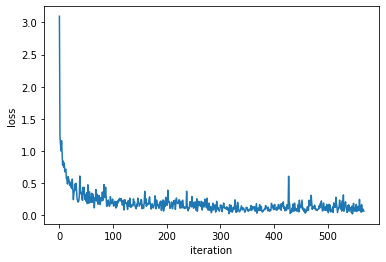

In [25]:
for epoch in range(2):
  model.train() # switching to training mode
  for iteration, batch in enumerate(dataloader_train):
      batch_inputs = {k: v.cuda(device) for k, v in list(batch[0].items())}
      batch_labels = batch[1].cuda(device)

      output = model(**batch_inputs)
      loss = CELoss(output.view(-1, output.size(-1)), batch_labels.view(-1))

      optimizer.zero_grad()
      loss.backward()

      optimizer.step()

      draw.append(loss.item())
      if (iteration + 1) % 30 == 0:
          print(f'{iteration:3} - loss: {loss.item()}')
  print("epoch{}: 완료\n".format(epoch + 1))
plt.plot(draw)
plt.xlabel("iteration")
plt.ylabel("loss")

# Test

loss: 2.2962698936462402
loss: 2.4392616748809814
loss: 1.6487936973571777
loss: 1.8338096141815186
loss: 1.7655131816864014
loss: 2.5150065422058105
loss: 2.05523419380188
loss: 2.4326059818267822
loss: 2.2958178520202637
loss: 2.428135395050049
loss: 2.382469892501831
loss: 2.0040743350982666
loss: 2.3216094970703125
loss: 2.0628702640533447
loss: 1.9809657335281372
loss: 2.2552077770233154
loss: 2.099591016769409
loss: 1.9974403381347656
loss: 2.3604884147644043
loss: 1.422490119934082
loss: 2.503875970840454
loss: 2.8165576457977295
loss: 2.363199472427368
loss: 2.1115078926086426
loss: 2.1336872577667236
loss: 2.1824028491973877
loss: 2.407421350479126
loss: 2.7196407318115234
loss: 2.3005619049072266
loss: 1.71058988571167
loss: 1.778895378112793
loss: 2.6114559173583984
loss: 2.103414535522461
loss: 2.7599101066589355


Text(0, 0.5, 'loss')

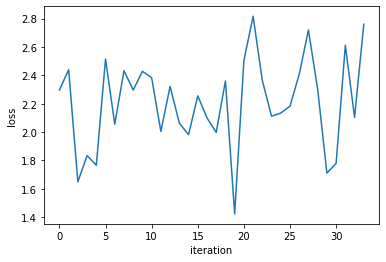

In [66]:
model.eval() # switching to evalutating mode: a function that turns off layers that should not be used in the evaluation process.

gold_list = [] # true
pred_list = []
draw_test = []

with torch.no_grad():
    for iteration, batch in enumerate(dataloader_test):
        batch_inputs = {k: v.cuda(device) for k, v in list(batch[0].items())}
        batch_labels = batch[1].cuda(device)

        output = model(**batch_inputs)

        loss = CELoss(output.view(-1, output.size(-1)), batch_labels.view(-1))

        print('loss:', loss.item())
        draw_test.append(loss.item())

        pred_ids = torch.argmax(output, dim = -1)
        
        # print(pred_ids)
        for g, p in zip(batch_labels, pred_ids):
            gold_mask = g != 0 #tag_converter.pad_id
            
            gold = convert_id_to_tag_list(g[gold_mask].tolist())
            pred = convert_id_to_tag_list(p[gold_mask].tolist())
            gold_list.append(gold)
            pred_list.append(pred)
            
            # print(gold)
            # print(pred)
plt.plot(draw_test)
plt.xlabel("iteration")
plt.ylabel("loss")

In [67]:
gold_list_flat = []
pred_list_flat = []
for g, p in zip(gold_list, pred_list):
    gold_list_flat += g
    pred_list_flat += p

In [68]:
tag_to_id ={'B-<휠': 1, 'B-OG': 2, 'I-조선': 3, 'I-PS': 4, 'B-LC': 5, 'B-1': 6, 'I-<휠': 7, 'I-LC': 8, 'B-PS': 9, 'I-TI': 10, 
              'B-목소': 11, 'O': 12, 'I-목소': 13, 'I-1': 14, 'I-': 15, 'B-조선': 16, 'I-OG': 17, 'B-': 18, 'I-DT': 19, 'B-TI': 20, 'B-DT': 21}

Precision:- Accuracy of positive predictions.

Precision = TP/(TP + FP)

 

Recall:- Fraction of positives that were correctly identified.

Recall = TP/(TP+FN)

 

F1 score

F1 Score = 2*(Recall * Precision) / (Recall + Precision)

 

Accuracy : (TP+TN) / all

 

macro avg = (normal+abnormal) /2 * precision or recall or f1 score

weighted avg = normal/(normal+abnormal)  *  precision or recall or f1 score

reference: https://datainsider.tistory.com/53

In [76]:
print(classification_report(gold_list_flat, pred_list_flat, target_names = ['B-<휠', 'B-OG', 'I-PS', 'B-LC', 'B-1', 'I-LC', 'B-PS','I-TI', 'O', 'I-1', 'I-OG', 'I-DT', 'B-TI', 'B-DT'])) # list(tag_to_id.keys())[1:]))

ValueError: ignored

In [65]:
from sklearn.metrics import accuracy_score
accuracy_score(gold_list_flat, pred_list_flat)

0.6770863623146264

In [59]:
def get_chunk_type(tag_name):
    tag_class = tag_name.split('-')[0]
    tag_type = tag_name.split('-')[-1]
    return tag_class, tag_type

In [40]:
def get_chunks(seq):
    default = "O"

    chunks = []
    chunk_type, chunk_start = None, None
    for i, tok in enumerate(seq):
        # End of a chunk 1
        if tok == default and chunk_type is not None:
            # Add a chunk.
            chunk = (chunk_type, chunk_start, i)
            chunks.append(chunk)
            chunk_type, chunk_start = None, None

        # End of a chunk + start of a chunk!
        elif tok != default:
            tok_chunk_class, tok_chunk_type = get_chunk_type(tok)
            if chunk_type is None:
                chunk_type, chunk_start = tok_chunk_type, i
            elif tok_chunk_type != chunk_type or tok_chunk_class == "B":
                chunk = (chunk_type, chunk_start, i)
                chunks.append(chunk)
                chunk_type, chunk_start = tok_chunk_type, i
        else:
            pass

    # end condition
    if chunk_type is not None:
        chunk = (chunk_type, chunk_start, len(seq))
        chunks.append(chunk)

    return chunks

In [37]:
def evaluate_ner_F1(total_answers, total_preds):
    num_match = num_preds = num_answers = 0

    for answers, preds in zip(total_answers, total_preds):

        answer_seg_result = set(get_chunks(answers))
        pred_seg_result = set(get_chunks(preds))

        num_match += len(answer_seg_result & pred_seg_result)
        num_answers += len(answer_seg_result)
        num_preds += len(pred_seg_result)

    precision = 100.0 * num_match / num_preds
    recall = 100.0 * num_match / num_answers
    F1 = 2 * precision * recall / (precision + recall)

    return precision, recall, F1

In [41]:
evaluate_ner_F1(gold_list, pred_list)

(6.690349319123742, 7.583892617449664, 7.10915382195659)